In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [ ]:
df = pd.read_csv('./film_reviews_result.csv', sep='|')

# EDA

In [ ]:
df.head()

,film_name,gender,film_avg_rate,review_rate,review_title,review_text
0,Respira (Serie de TV),"Serie de TV, Drama, Medicina","4,6",1,Respira,"Como fan de las series españolas y de Najwa, e..."
1,Respira (Serie de TV),"Serie de TV, Drama, Medicina","4,6",2,Esta serie te llama tonto a la cara,Todo lo malo que puede tener una serie lo pose...
2,Respira (Serie de TV),"Serie de TV, Drama, Medicina","4,6",1,Respira,"La serie es un drama médico que intenta ""copia..."
3,Respira (Serie de TV),"Serie de TV, Drama, Medicina","4,6",1,"Imposible, no hay manera",Nadie te obliga a ver nada que no quieras ver ...
4,Respira (Serie de TV),"Serie de TV, Drama, Medicina","4,6",1,Serie nefasta,Está serie da vergüenza ajena. Una serie donde...


In [ ]:
df.describe()

,review_rate
count,10058.000000
mean,5.852456
std,2.407915
min,1.000000
25%,4.000000
50%,6.000000
75%,8.000000
max,10.000000


Como con 10k nos sobra, vamos a quedarnos con las primera 1k solamente

In [ ]:
df['review_text'].iloc[69]

'Me encanta este tipo de películas, de hecho la recomendaría. Me gusta la acción, me gustan las persecuciones, el espionaje, los protagonistas, la historia. De hecho , es una buena película de acción que te hará pasar un buen rato. Las cosas que no entiendo las explicaré en la zona spoiler, porque sino no tiene ningún sentido.'

Realmente solo me interesa la resena para hacer el analisis y la valoracion como target.

In [ ]:
df = df[['review_rate','review_text']]

In [ ]:
df.head()

,review_rate,review_text
0,1,"Como fan de las series españolas y de Najwa, e..."
1,2,Todo lo malo que puede tener una serie lo pose...
2,1,"La serie es un drama médico que intenta ""copia..."
3,1,Nadie te obliga a ver nada que no quieras ver ...
4,1,Está serie da vergüenza ajena. Una serie donde...


In [ ]:
def sentimiento_txt(estrellas):
  if estrellas <= 5:
    return "negativo"
  else:
    return "positivo"

df["label_txt"] = df['review_rate'].apply(sentimiento_txt)

df.head()

,review_rate,review_text,label_txt
0,1,"Como fan de las series españolas y de Najwa, e...",negativo
1,2,Todo lo malo que puede tener una serie lo pose...,negativo
2,1,"La serie es un drama médico que intenta ""copia...",negativo
3,1,Nadie te obliga a ver nada que no quieras ver ...,negativo
4,1,Está serie da vergüenza ajena. Una serie donde...,negativo


In [ ]:
df_entero = df
print(f'Entero: {df_entero.shape}')
df = df[:1000]
print(f'Cortado: {df.shape}')

Entero: (10058, 3)
Cortado: (1000, 3)


Con 10k para este modelo nos sobra, asique nos quedaremos con 1k solamente.
Igualmente guardamos el dataframe entero para luego.

Text(0.5, 0, 'Valoracion')

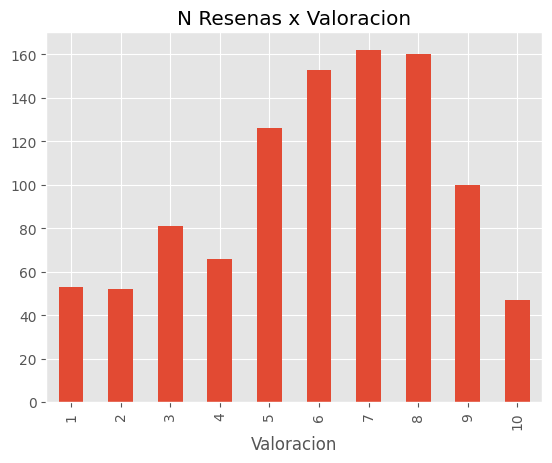

In [ ]:
bar = df['review_rate'].value_counts().sort_index().plot(kind='bar', title='N Resenas x Valoracion')
bar.set_xlabel('Valoracion')

Text(0.5, 0, '')

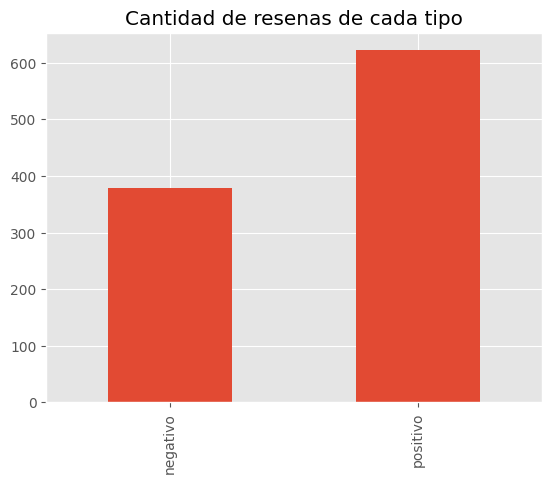

In [ ]:
df['label_txt'].value_counts().sort_index().plot(kind='bar', title='Cantidad de resenas de cada tipo').set_xlabel("")

Veo que el dataset esta desbalanceado, algo que tendre que tener en cuenta a la hora de hacer el modelo

# Modelos

Primero, voy a crear mi propio modelo de analisis de sentimiento usnado BoW y Regresion. Despues usare un modelo preentrenado con redes neuronales transformer para asi tener contexto de la frase.

# Modelo Sencillo

In [ ]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 60.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import spacy
nlp = spacy.load("es_core_news_sm")

Creo una nueva columna agrupando el score

In [ ]:
def tokenizer_es(text):
  doc = nlp(text)
  return [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

Al ser TfidfVectorizer solo tokenizar para ingles, vamos a pasarle nuestro propio tokenizer.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['review_text'], df['label_txt'], test_size=0.2, random_state=42, stratify=df['label_txt'])

In [ ]:
pipeline = Pipeline([
    ("prep", TfidfVectorizer(tokenizer=tokenizer_es, lowercase=True, max_features=5000)),
    ("pred", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

pipeline.fit(x_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('prep',
                 TfidfVectorizer(max_features=5000,
                                 tokenizer=<function tokenizer_es at 0x7e5b071dee80>)),
                ('pred',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [ ]:
y_pred = pipeline.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negativo       0.66      0.71      0.68        76
    positivo       0.81      0.77      0.79       124

    accuracy                           0.75       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.75      0.75      0.75       200



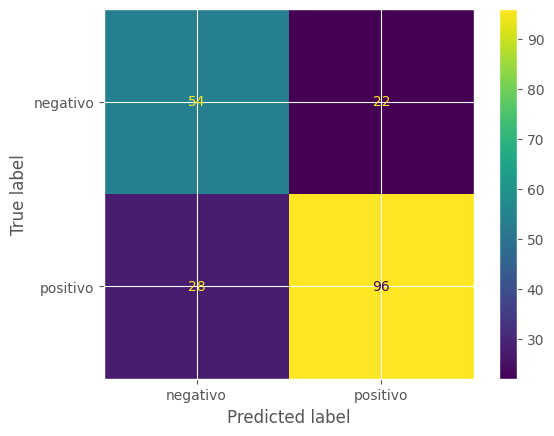

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
plt.show()

In [ ]:
print(pipeline.predict(["Vaya mierda, es malisima"]))
print(pipeline.predict(["Me ha gustado mucho la peli, ese actor es el mejor me encanta"]))
print(pipeline.predict(["No es nada mala, al reves, me ha impresionado para bien"]))

['negativo']
['positivo']
['negativo']


Vemos que nuestro modelo logra predecir mas o menos, aunque al no tener en cuenta el contexto de la frase en palabras que son "oximorones" o que se contradicen, como en el ultimo ejemplo: "no eres nada malo", el modelo ve las palabras "nada" o "malo", y piensa que es algo negativo

# Modelo complejo

Como entrenar un modelo transformer desde cero, requiere muchos recursos y dinero, vamos a usar un modelo preentrenado y le vamos a hacer fine-tuning para adaptarlo a nuestro caso.

In [ ]:
!pip install transformers datasets accelerate torch

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODELO = "verotei/bert-base-spanish-wwm-cased-nlp-transformers-sentiment-amazon"
tokenizer = AutoTokenizer.from_pretrained(MODELO)
model = AutoModelForSequenceClassification.from_pretrained(MODELO)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Elegimos un modelo que soporte el Espanol

In [ ]:
def pred_bert(txt):
  encoded_text = tokenizer(txt, return_tensors='pt', padding=True, truncation=True)
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
      "bert_neg": scores[0],
      "bert_pos": scores[1]
  }
  return scores_dict

print(pred_bert("Vaya mierda, es malisima"))
print(pred_bert("Me ha gustado mucho la peli, ese actor es el mejor me encanta"))
print(pred_bert("No es nada mala, de hecho me ha sorprendido para bien"))

{'bert_neg': np.float32(0.99552983), 'bert_pos': np.float32(0.0044701817)}
{'bert_neg': np.float32(0.0009911158), 'bert_pos': np.float32(0.9990089)}
{'bert_neg': np.float32(0.0009345654), 'bert_pos': np.float32(0.99906546)}


Vemos que aunque no hayamos hecho el fine tunning, el modelo ya es notablemente muy superior al anterior.

In [ ]:
from tqdm.auto import tqdm

bert_preds = []
labels = {0: 'negativo', 1: 'positivo'}

for test in tqdm(x_test, desc="Evaluacion modelo bert"):
  score = pred_bert(test)
  pred_index = np.argmax(list(score.values()))
  bert_preds.append(labels[pred_index])

print(classification_report(y_test, bert_preds))


Evaluacion modelo bert:   0%|          | 0/200 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    negativo       0.72      0.66      0.69        76
    positivo       0.80      0.85      0.82       124

    accuracy                           0.78       200
   macro avg       0.76      0.75      0.76       200
weighted avg       0.77      0.78      0.77       200



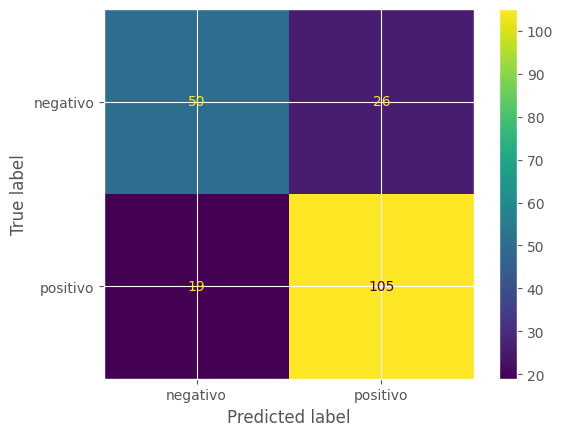

In [ ]:
cm_bert = confusion_matrix(y_test, bert_preds, labels=pipeline.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm_bert, display_labels=pipeline.classes_).plot()

Los resultados del modelo bert me han sorprendido bastante para mal, me esperaba algo mejor, vamos a hacer algunas pruebas manuales, sobre todo de criticas negativas que son las que mas fala

In [ ]:
print(pred_bert("No me ha gustado mucho la verdad"))
print(pred_bert("Batante floja, me esperaba mas"))
print(pred_bert("Casi me duermo viendo la peli, me ha decepcionado"))
print(pred_bert("Mas aburrida imposible"))
print(pred_bert("La mejor parte es cuando se acaba"))

{'bert_neg': np.float32(0.8218413), 'bert_pos': np.float32(0.17815867)}
{'bert_neg': np.float32(0.9889753), 'bert_pos': np.float32(0.011024727)}
{'bert_neg': np.float32(0.9906784), 'bert_pos': np.float32(0.009321565)}
{'bert_neg': np.float32(0.96588254), 'bert_pos': np.float32(0.034117427)}
{'bert_neg': np.float32(0.00967361), 'bert_pos': np.float32(0.99032634)}


Sin embargo veo que las pruebas manuales las acierta todas, menos la ultima que era rtealmente dificil ya que es una critica totalmente ironica y dificil de detectar